### Import relevant libraries

In [1]:
import pathlib
import os
import datetime
import json
import sys

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Input, Dropout
from tensorflow.keras.models import Model
# from tensorflow.keras.regularizers import L2

In [ ]:
import mlflow
mlflow.tensorflow.autolog()

In [ ]:
import prd_pipeline

In [ ]:
data_prep_dir = pathlib.Path(os.environ['HOME']) / 'code/git' / 'precip_rediagnosis' / 'data_prep'
sys.path.append(str(data_prep_dir))
import drivers

### Load and preprocess data

In [7]:
configs_dir = data_prep_dir / 'event_configs'
configs_dir.is_dir(), configs_dir

(True,
 PosixPath('/home/h02/hbrown/code/git/precip_rediagnosis/data_prep/event_configs'))

In [8]:
events = [
    '2020_storm_dennis', 
    '2020_storm_ciara',
    '2020_amber_nswws_oct',
    '2020_amber_nswws_dec',
    '2021_amber_nswws_feb',
    '2021_amber_nswws_oct',
    '2021_storm_barra',
    '2022_storm_eunice_franklin', 
    '2020_storm_ellen', 
    '2020_storm_francis'
]

In [9]:
root_data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis')
prd_train_data = root_data_dir / 'train202208'

In [10]:
def get_file_name(event, configs_dir):
    config_path = configs_dir  / f'{event}.json'
    print('config file exists:', config_path.is_file())
    with open(config_path) as config_file:
        dataset_config = json.load(config_file)

    event_start_dt = datetime.datetime.strptime(dataset_config['event_start'], '%Y-%m-%dT%H:%MZ')
    event_end_dt = datetime.datetime.strptime(dataset_config['event_end'], '%Y-%m-%dT%H:%MZ')
    times_list = drivers.calc_dates_list(event_start_dt, event_end_dt, float(dataset_config['target_time_delta']))
    final_timestamp = max(times_list)  # Data extract isn't inclusive of final date so need second last time 

    start_datestring = f'{event_start_dt.year:04d}{event_start_dt.month:02d}{event_start_dt.day:02d}T{event_start_dt.hour:02d}{event_start_dt.minute:02d}Z'
    end_datestring = f'{event_end_dt.year:04d}{event_end_dt.month:02d}{event_end_dt.day:02d}T{event_end_dt.hour:02d}{event_end_dt.minute:02d}Z'
    final_datestring = f'{final_timestamp.year:04d}{final_timestamp.month:02d}{final_timestamp.day:02d}T{final_timestamp.hour:02d}{final_timestamp.minute:02d}Z'
    event_name = dataset_config["event_name"]
    return f'{event_name}/prd_merged_{start_datestring}_{final_datestring}.csv'

In [11]:
target_parameter = [
    'radar_fraction_in_band_instant_0.25', 
    'radar_fraction_in_band_instant_2.5',
    'radar_fraction_in_band_instant_7.0',
    'radar_fraction_in_band_instant_10.0'
]
profile_features = ['air_temperature', 'relative_humidity']#, 'cloud_volume_fraction', 'air_pressure']
single_lvl_features = []#['surface_altitude']#['thickness_of_rainfall_amount']#['air_pressure_at_sea_level'] 

In [12]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
} 

In [13]:
events_data_test = []
events_data_train = []

test_fraction = 0.2

for event in events:
    print(event)
    data_path = prd_train_data / get_file_name(event, configs_dir)
    
    tmpdat = pd.read_csv(data_path)
    tmpdat['time'] = pd.to_datetime(tmpdat['time'])
    tmpdat['forecast_reference_time'] = pd.to_datetime(tmpdat['forecast_reference_time'])
    
    df_train, df_test = prd_pipeline.random_time_space_sample(tmpdat, test_fraction=test_fraction, random_state=np.random.RandomState(), sampling_columns = ['time', 'latitude', 'longitude'])
    events_data_test.append(df_test)
    data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

    events_data_train.append(data_splits)

2020_storm_dennis
config file exists: True
target has dims: 4
dropping smallest bin: radar_fraction_in_band_instant_0.25
getting profile columns
{'profile': ['air_temperature', 'relative_humidity'], 'single_level': [], 'target': ['radar_fraction_in_band_instant_0.25', 'radar_fraction_in_band_instant_2.5', 'radar_fraction_in_band_instant_7.0', 'radar_fraction_in_band_instant_10.0']}
2020_storm_ciara
config file exists: True
target has dims: 4
dropping smallest bin: radar_fraction_in_band_instant_0.25
getting profile columns
{'profile': ['air_temperature', 'relative_humidity'], 'single_level': [], 'target': ['radar_fraction_in_band_instant_0.25', 'radar_fraction_in_band_instant_2.5', 'radar_fraction_in_band_instant_7.0', 'radar_fraction_in_band_instant_10.0']}
2020_amber_nswws_oct
config file exists: True
target has dims: 4
dropping smallest bin: radar_fraction_in_band_instant_0.25
getting profile columns
{'profile': ['air_temperature', 'relative_humidity'], 'single_level': [], 'target':

In [14]:
data_test = pd.concat(events_data_test)
data_test.to_csv('prd_merged_all_events_test_dataset.csv')

In [15]:
data_splits = {
    'X_train': np.concatenate([event['X_train'] for event in events_data_train]),
    'X_val': np.concatenate([event['X_val'] for event in events_data_train]), 
    'y_train': pd.concat([event['y_train'] for event in events_data_train]),
    'y_val': pd.concat([event['y_val'] for event in events_data_train]),
}

### Visualise and compare the distributions in the train, validate and test samples

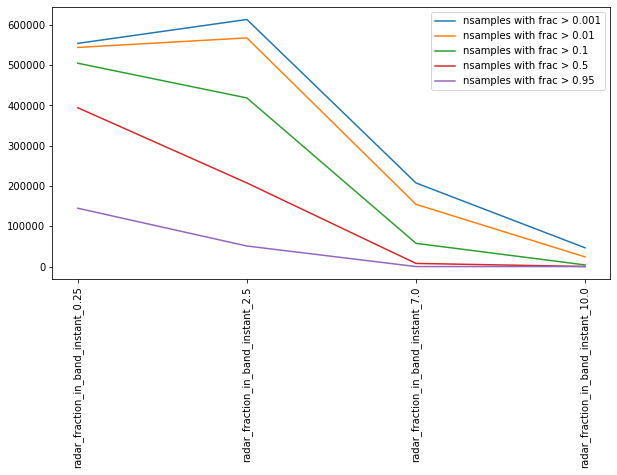

In [16]:
for frac in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(data_dims_dict['nbands']):
        exceeding_prob.append(sum(data_splits['y_train'].iloc[:, thresh] > frac))
    plt.plot(np.arange(data_dims_dict['nbands']), exceeding_prob, label=f'nsamples with frac > {frac}')
plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

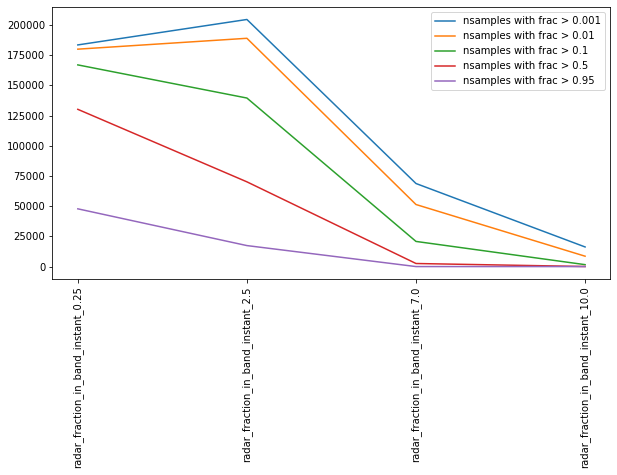

In [17]:
for prob in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(data_dims_dict['nbands']):
        exceeding_prob.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
    plt.plot(np.arange(data_dims_dict['nbands']), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

For the train, validate and test samples, plot the distribution of number of samples in the different intensity bands that exceed a variety of threshold limits (each plot shows a different threshold limit)

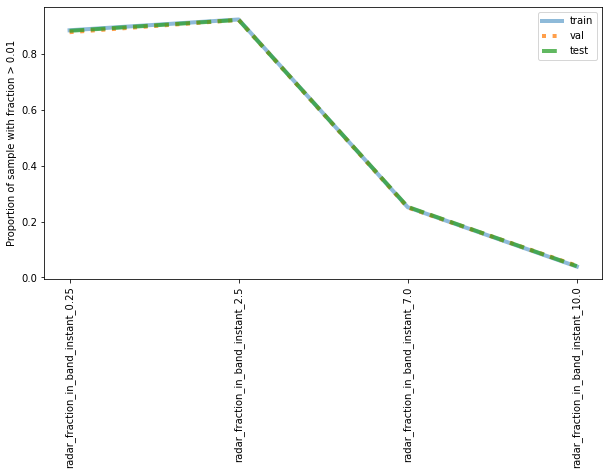

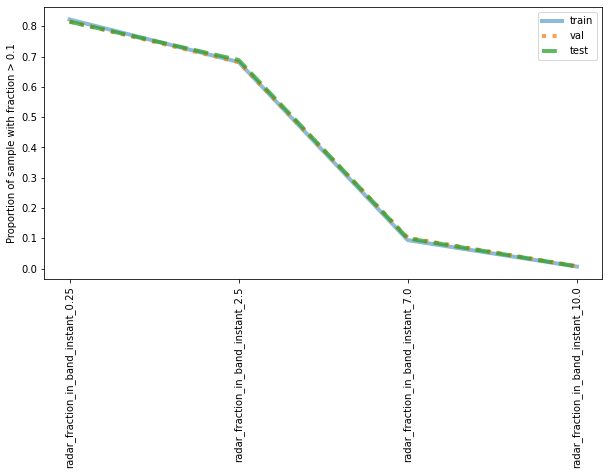

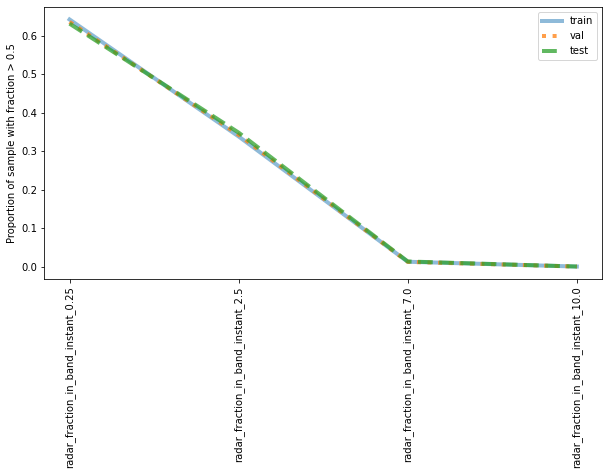

In [18]:
test_sub = data_test[data_test[feature_dict['target'][0]]!=1]  # train and validate have had this preprocessing already applied 
for prob in [0.01, 0.1, 0.5]:
    train, val, test = [], [], []
    for thresh in range(data_dims_dict['nbands']):
        test.append(sum(test_sub[target_parameter].iloc[:, thresh] > prob)/len(test_sub))
        val.append(sum(data_splits['y_val'].iloc[:, thresh] > prob)/len(data_splits['y_val']))
        train.append(sum(data_splits['y_train'].iloc[:, thresh] > prob)/len(data_splits['y_train']))
    
    plt.plot(np.arange(data_dims_dict['nbands']), train, label=f'train', lw=4, alpha=0.5)
    plt.plot(np.arange(data_dims_dict['nbands']), val, label=f'val', ls=':', lw=4, alpha=0.75)
    plt.plot(np.arange(data_dims_dict['nbands']), test, label=f'test', ls='--', lw=4, alpha=0.75)

    plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
    plt.legend()
    plt.ylabel(f'Proportion of sample with fraction > {prob}')
    plt.gcf().set_size_inches(10, 5)
    plt.show()

### Resample data

Resample data to create more uniform distribution within the training data

In [19]:
# data_splits['y_train']['max_bin'] = data_splits['y_train'].idxmax(axis=1)

# nsamples = len(data_splits['y_train'])//len(data_splits['y_train'].columns)

# y_train = pd.DataFrame()

# data_splits['y_train'] = data_splits['y_train'].reset_index(drop=True)
# for col in data_splits['y_train'].columns[0:-1]:
#     ids = data_splits['y_train'][data_splits['y_train']['max_bin']==col].index
#     if len(ids)>0:
#         choices = np.random.choice(ids, nsamples)
#         y_train = pd.concat([y_train, data_splits['y_train'].loc[choices]])
#         try: 
#             X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
#         except NameError:
#             X_train = data_splits['X_train'][choices]

# cols = data_splits['y_train'].columns[:-1]
# plt.plot(data_splits['y_train'].sum(axis=0)[cols], label='original data')
# plt.plot(y_train.sum(axis=0)[cols], label='resampled data')
# plt.legend()
# plt.show()

# y_train = y_train.drop(columns=['max_bin'])

# data_splits['X_train'] = X_train
# data_splits['y_train'] = y_train
# data_dims_dict['nbands'] = data_splits['y_train'].shape[1]

## Set up model and experiment

In [20]:
def build_model(nprof_features, nheights, nsinglvl_features, nbands=23):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu')(out) #use_bias=False, bias_initializer='zeros'
    out = Dropout(0.1)(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, activation='relu')(out) # use_bias=False,
    # out = Dropout(0.1)(out)

    if nsinglvl_features > 0:
        surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
        flat_profs = Flatten()(profile_input)
        raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
        raw_size = (nheights*nprof_features)+nsinglvl_features

        out = tf.keras.layers.concatenate([out, surf_input])
        x = tf.keras.layers.add([out, raw_in])
        x = Dense(1024, activation='relu')(x)
        x = Dense(1024, activation='relu')(x)

        main_output = Dense(nbands, use_bias=True, activation='softmax', name='main_output')(x)
        model = Model(inputs=[profile_input, surf_input], outputs=[main_output])

    else:
        main_output = Dense(nbands, activation='softmax', name='main_output')(out) # use_bias=True, 
        model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [21]:
def train_model(model, data_splits):
    # TODO: these hyperparameters should be read in from somewhere?
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss=tf.keras.losses.KLDivergence(), optimizer=optimizer, metrics=['accuracy'],)

    history = model.fit(data_splits['X_train'], 
                        data_splits['y_train'], 
                        epochs=20, 
                        batch_size=100, 
                        validation_data=(data_splits['X_val'], data_splits['y_val']),  verbose=True)
    return model, history

In [22]:
# exp = mlflow.create_experiment(f'prd_{radar_type}')
exp1 = mlflow.get_experiment('3')
exp1

<Experiment: artifact_location='file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns/3', experiment_id='3', lifecycle_stage='active', name='prd_radar_fraction_in_band_instant', tags={}>

In [23]:
hyperparameter_dict = {
    'loss_function': tf.keras.losses.KLDivergence(),
    'epochs': 20, 
    'learning_rate': 0.001, 
    'batch_size': 500
}

In [24]:
with mlflow.start_run(experiment_id=exp1.experiment_id, run_name='multi_event_only_time_sampling') as current_run:
    mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])
    # model = build_model(**data_dims_dict)
    # model.summary()
    # model, history = train_model(model, data_splits)
    
    model = prd_pipeline.build_model(**data_dims_dict)
    model.summary()
    model = prd_pipeline.train_model(model, data_splits, hyperparameter_dict)
    

2022-08-15 16:09:38.295079: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 2)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 35, 2)       0           ['profile_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 33, 32)       192         ['zero_padding1d[0][0]']         
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 32)      0           ['conv1d[0][0]']                 
 D)                                                                                           

/home/h02/hbrown/.conda/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
1228/1228 [==============================] - 15s 11ms/step - loss: 0.3378 - val_loss: 0.3254
Epoch 2/20
1228/1228 [==============================] - 14s 11ms/step - loss: 0.3143 - val_loss: 0.3166
Epoch 3/20
1228/1228 [==============================] - 15s 12ms/step - loss: 0.3041 - val_loss: 0.3077
Epoch 4/20
1228/1228 [==============================] - 14s 11ms/step - loss: 0.2963 - val_loss: 0.3045
Epoch 5/20
1228/1228 [==============================] - 14s 11ms/step - loss: 0.2902 - val_loss: 0.2999
Epoch 6/20
1228/1228 [==============================] - 14s 12ms/step - loss: 0.2853 - val_loss: 0.2949
Epoch 7/20
1228/1228 [==============================] - 14s 11ms/step - loss: 0.2812 - val_loss: 0.2922
Epoch 8/20
1228/1228 [==============================] - 14s 11ms/step - loss: 0.2770 - val_loss: 0.2916
Epoch 9/20
1228/1228 [==============================] - 13s 11ms/step - loss: 0.2735 - val_loss: 0.2868
Epoch 10/20
1228/1228 [==============================] - 13s 11m

2022-08-15 16:14:18.605644: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/tmp/tmpj_01f5fi/model/data/model/assets


/home/h02/hbrown/.conda/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/h02/hbrown/.conda/envs/prd_ml/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [25]:
y_pred = model.predict(data_splits['X_val'])

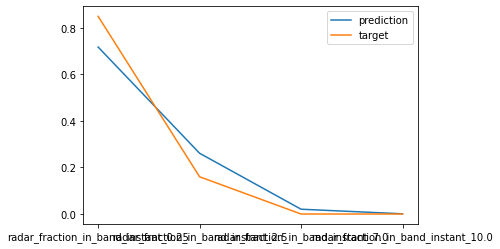

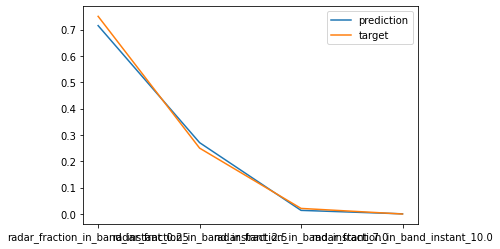

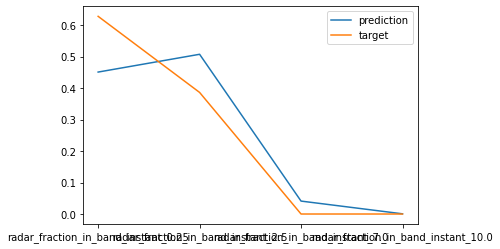

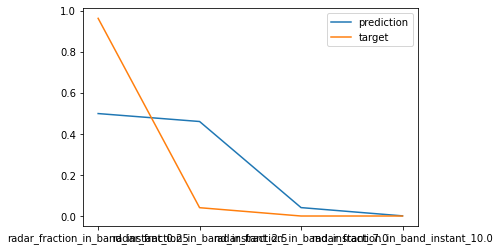

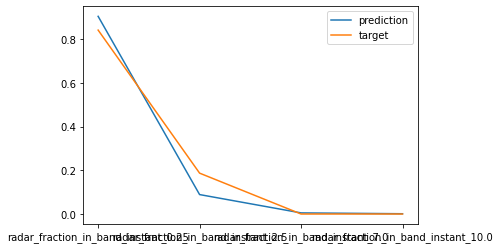

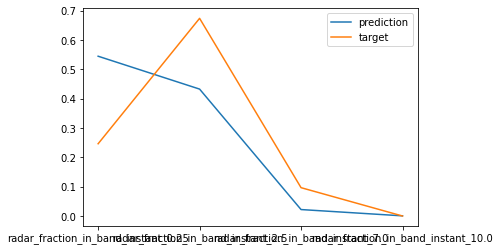

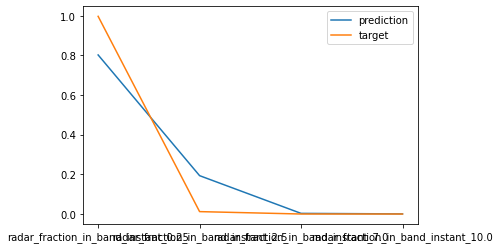

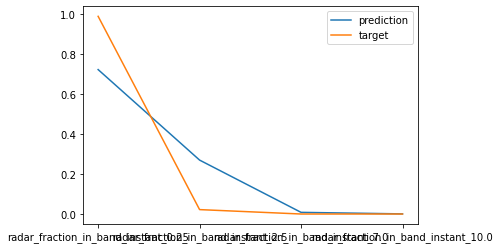

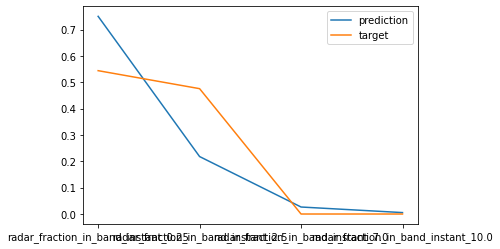

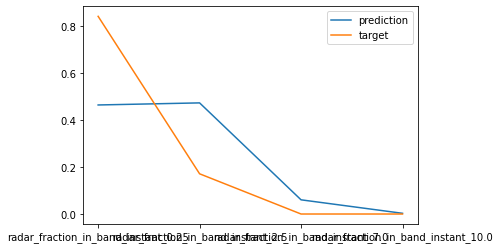

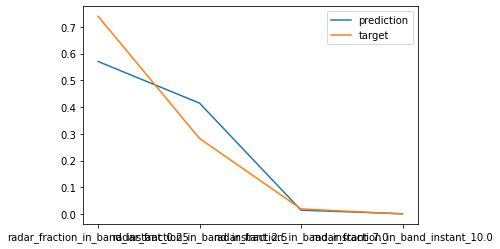

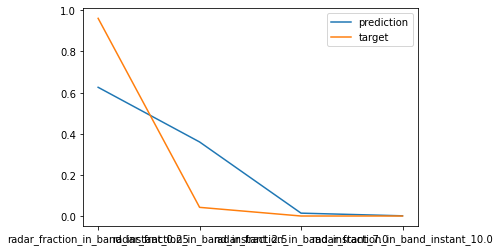

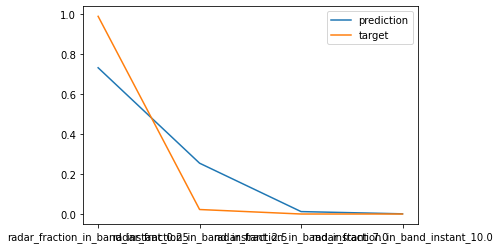

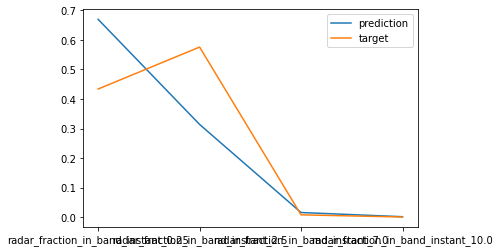

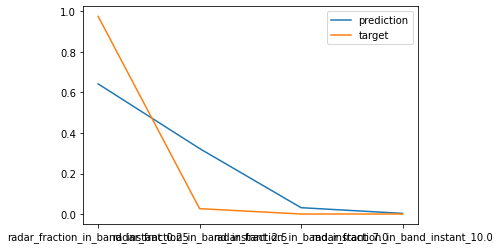

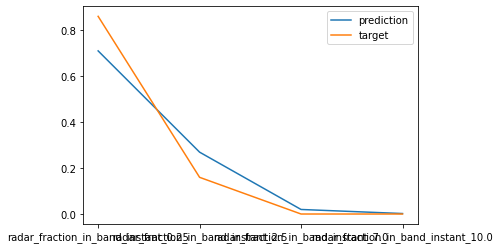

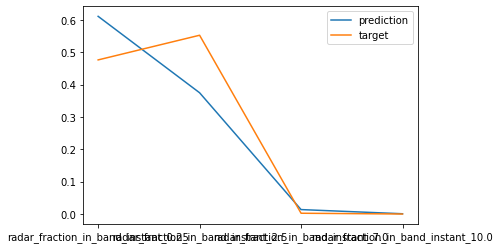

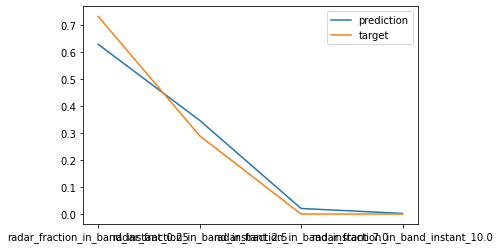

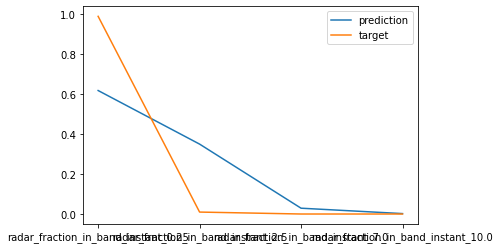

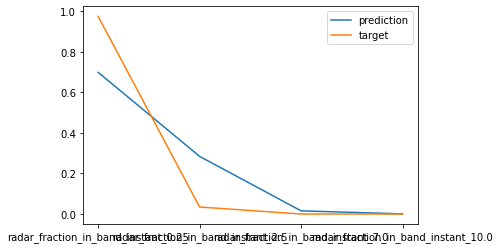

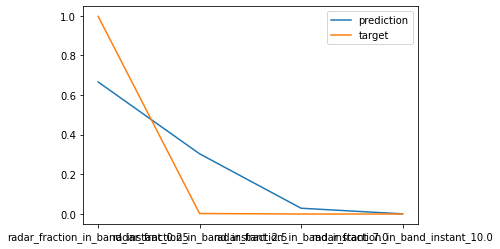

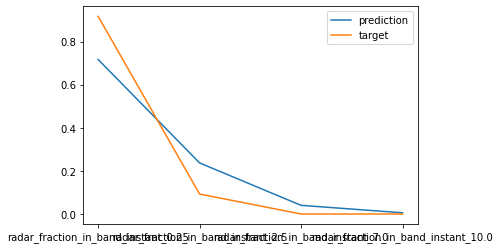

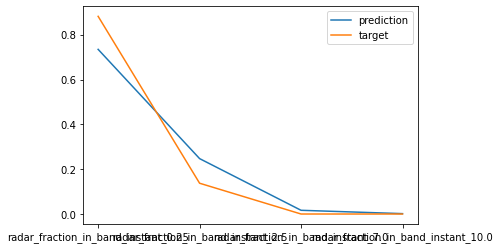

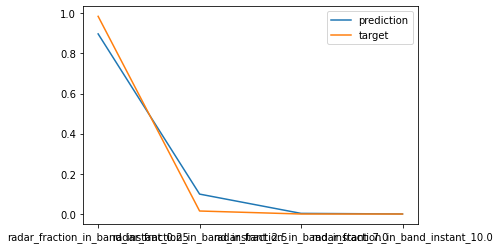

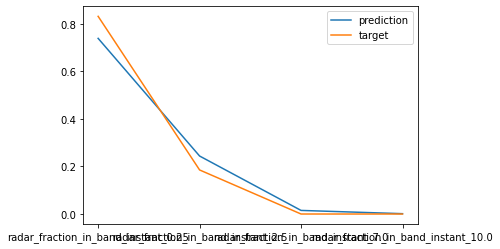

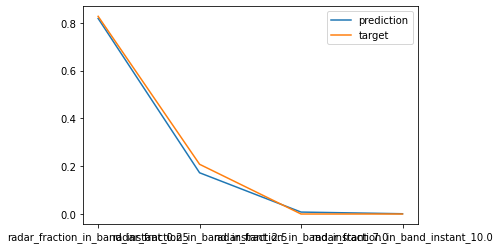

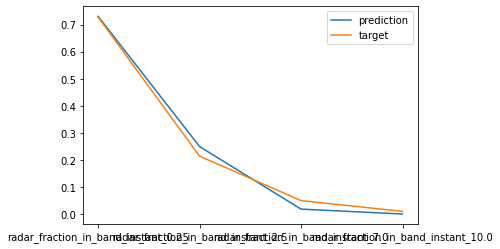

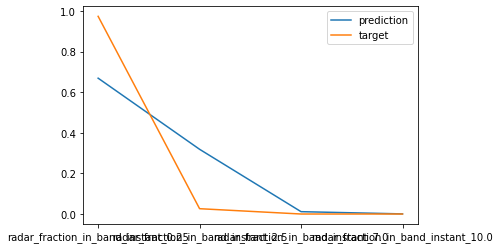

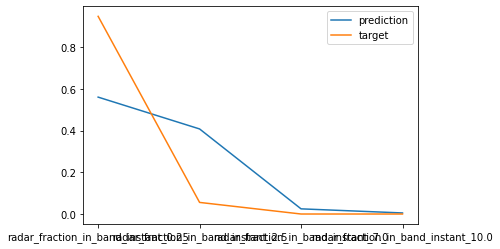

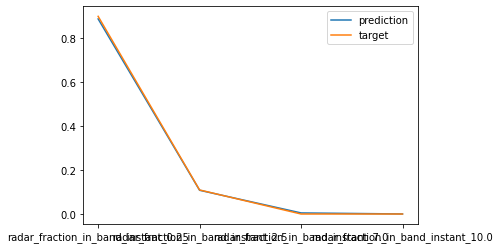

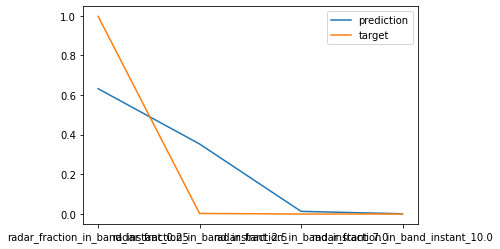

In [26]:
for loc in np.arange(0,541,18):
    plt.plot(y_pred[loc], label='prediction')
    plt.plot(data_splits['y_val'].iloc[loc], label='target')
    plt.legend()
    plt.show()

### Calculate fractional skill score

Here we use y_pred as the forecast and radar fractions from y_val as the observation. 

In [27]:
data_splits['y_val']

,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
0,0.849412,0.160000,0.0,0.0
1,0.849412,0.160000,0.0,0.0
2,0.849412,0.160000,0.0,0.0
3,0.849412,0.160000,0.0,0.0
4,0.849412,0.160000,0.0,0.0
...,...,...,...,...
60925,0.895954,0.118497,0.0,0.0
60926,0.895954,0.118497,0.0,0.0
60927,0.895954,0.118497,0.0,0.0
60928,0.895954,0.118497,0.0,0.0


In [28]:
cols = data_splits['y_val'].columns
for i, col in enumerate(cols):
    FBS = (y_pred[:,:i+1].sum(axis=1) - data_splits['y_val'][cols[:i+1]].sum(axis=1))**2
    FBS_ref = y_pred[:,:i+1].sum(axis=1)**2 + data_splits['y_val'][cols[:i+1]].sum(axis=1)**2
    FSS = np.mean(1 - (FBS/FBS_ref))
    print(f'The FSS for predicting {col}mm/hh is {FSS}')

The FSS for predicting radar_fraction_in_band_instant_0.25mm/hh is 0.7577201570286739
The FSS for predicting radar_fraction_in_band_instant_2.5mm/hh is 0.9905853526634332
The FSS for predicting radar_fraction_in_band_instant_7.0mm/hh is 0.9993998928876027
The FSS for predicting radar_fraction_in_band_instant_10.0mm/hh is 0.9997995573214005
